In [1]:
import os
os.chdir("../")

import sys
sys.path.append(os.getcwd())

import torch
from diffusers import DiffusionPipeline
from src.hooked_model.hooked_model_sdxl import HookedDiffusionModel
import matplotlib.pyplot as plt
import einops
import numpy as np
from datasets import Dataset
from PIL import Image
from tqdm import tqdm

torch.backends.cuda.matmul.allow_tf32 = True
torch._inductor.config.conv_1x1_as_mm = True
torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.epilogue_fusion = False
torch._inductor.config.coordinate_descent_check_all_directions = True

/net/tscratch/people/plgwlapacz/conda_envs/zzsn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare SDXL

In [2]:
pipe_sd_turbo = DiffusionPipeline.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

hooked_model = HookedDiffusionModel(
    model=pipe_sd_turbo.unet,
    scheduler=pipe_sd_turbo.scheduler,
    encode_prompt=pipe_sd_turbo.encode_prompt,
    vae=pipe_sd_turbo.vae,
)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


Prepare SAE

In [3]:
dtype = torch.float16
device = "mps" if torch.backends.mps.is_available() else "cuda"
ckpt_path = (
    "sae-diff-autointerpr/checkpoints/batch_topk_expansion_factor16_k32_multi_topkFalse_auxk_alpha0.03125_output_249_output"
)
hookpoint = "down_blocks.2"

from src.sae.sae import Sae

sae = Sae.load_from_disk(
	os.path.join(
		ckpt_path,
		hookpoint,
	),
	device=device,
).to(dtype)

Prepare activations dataset

In [4]:
num_timesteps = 4
activations_dataset_path = f"sae-diff-autointerpr/activations/activations/sdxl-turbo/steps{num_timesteps}"
activations_dataset = Dataset.load_from_disk(
	os.path.join(activations_dataset_path, hookpoint), keep_in_memory=False
)
activations_dataset.set_format(
	type="torch", columns=["activations", "timestep", "file_name"], dtype=dtype
)
activations_dataset = activations_dataset.filter(
	lambda x: x["timestep"] == 249, batched=True
)

In [5]:
avg_activations_per_sample = torch.zeros(
	(len(activations_dataset), sae.num_latents), dtype=torch.float16
)

batch_size = 16
dl = torch.utils.data.DataLoader(
	activations_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
with torch.no_grad():
	for i, batch in tqdm(enumerate(dl), total=len(dl)):
		acts = batch["activations"].to(sae.device)
		acts = einops.rearrange(
			acts,
			"batch sample_size d_model -> (batch sample_size) d_model",
		)
		out = sae.pre_acts(acts)
		# Reshape to get per-sample activations and compute mean for each sample
		out = out.view(
			batch["activations"].shape[0], -1, sae.num_latents
		)  # [batch, sample_size, num_latents]
		batch_avg_activations = out.mean(dim=1).to(
			dtype=torch.float16
		)  # [batch, num_latents]

		# Store in the correct indices
		start_idx = i * batch_size
		end_idx = min(start_idx + batch_size, len(activations_dataset))
		avg_activations_per_sample[start_idx:end_idx] = batch_avg_activations

100%|██████████| 313/313 [00:15<00:00, 19.60it/s]


In [6]:
def find_topk_activating_examples(activations_per_sample, latent_idx, k=10):
	topk_indices = torch.argsort(
		activations_per_sample[:, latent_idx], dim=0, descending=True
	)[:k]
	return topk_indices


k = 5
latent_idx = 6531  #374

topk_indices = find_topk_activating_examples(
    avg_activations_per_sample, latent_idx, k
)  # find topk samples containing patches with higest activations
topk_samples = activations_dataset[topk_indices.tolist()]
sae_latents = []
activations = topk_samples["activations"].to(sae.device)
timesteps = topk_samples["timestep"]
file_names_topk = topk_samples["file_name"]
activations = einops.rearrange(
    activations,
    "batch sample_size d_model -> (batch sample_size) d_model",
)
out = sae.pre_acts(activations)
sae_latents = out.view(k, -1, sae.num_latents)

Take only captions corresponding to the selected images

In [7]:
import json

with open("/net/pr2/projects/plgrid/plggzzsn2025/coco/annotations/captions_val2017.json", "r") as f:
    captions = json.load(f)

ids = [int(os.path.splitext(name.split("/")[1])[0]) for name in file_names_topk]
captions = [item['caption'] for item in captions["annotations"] if item['image_id'] in ids]
if len(captions) > 32:
    captions = captions[:32]

Generate activations corresponding to these prompts

In [8]:
new_avg_activations_per_sample = torch.zeros(
	(len(captions), sae.num_latents), dtype=torch.float16
)
bsz = 16
with torch.no_grad():
	for i in range(0, len(captions), bsz):
		end_idx = min(i + bsz, len(captions))
		_, cache_dict = hooked_model.run_with_cache(
			prompt=captions[i:end_idx],
			num_images_per_prompt=1,
			device="cuda",
			guidance_scale=7.5,
			num_inference_steps=249,
			height=640,
			width=480,
			generator=torch.Generator(device="cuda").manual_seed(1),
			positions_to_cache=["down_blocks.2"],
		)
		acts = cache_dict["output"]["down_blocks.2"][:, -1]
		acts = einops.rearrange(
			acts,
			"batch sample_size d_model -> (batch sample_size) d_model",
		)
		out = sae.pre_acts(acts)
		# Reshape to get per-sample activations and compute mean for each sample
		out = out.view(
			end_idx-i, -1, sae.num_latents
		)  # [batch, sample_size, num_latents]
		batch_avg_activations = out.mean(dim=1).to(
			dtype=torch.float16
		)  # [batch, num_latents]

		start_idx = i
		new_avg_activations_per_sample[start_idx:end_idx] = batch_avg_activations

In [9]:
avg_activations = avg_activations_per_sample[topk_indices.tolist()].mean(dim=0).cpu().numpy()
new_avg_activations = new_avg_activations_per_sample.mean(dim=0).cpu().numpy()

In [10]:
print(avg_activations_per_sample[topk_indices.tolist()].shape, new_avg_activations_per_sample.shape)

torch.Size([5, 20480]) torch.Size([25, 20480])


Plot differences on all SAE features

In [11]:
abs_diff = abs(avg_activations - new_avg_activations)

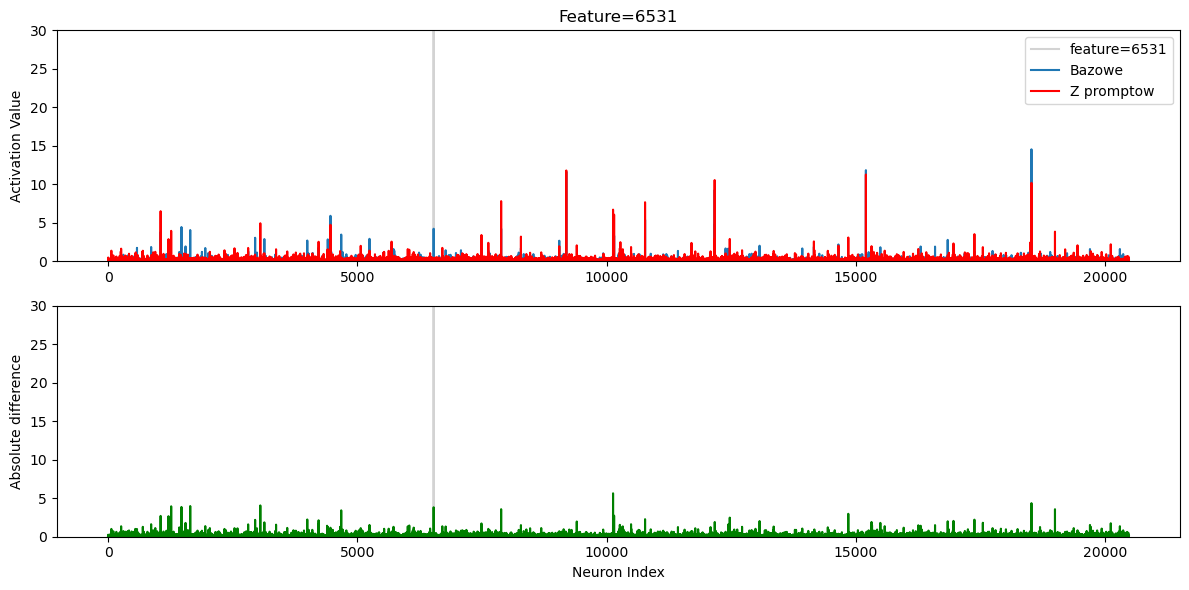

In [18]:
mask = np.zeros(len(avg_activations))
mask[latent_idx] = 30
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(
    np.arange(len(avg_activations)),
    mask,
    label=f"feature={latent_idx}",
    color="lightgray"
)
ax1.plot(
    np.arange(len(avg_activations)),
    avg_activations,
    label="Bazowe"
)
ax1.plot(
    np.arange(len(new_avg_activations)),
    new_avg_activations,
    color="red",
    label="Z promptow"
)
ax1.set_ylim(0, 30)
ax1.set_ylabel("Activation Value")
ax1.set_title(f"Feature={latent_idx}")
ax1.legend()

ax2.plot(
    np.arange(len(avg_activations)),
    mask,
    color="lightgray"
)
ax2.plot(
    np.arange(len(avg_activations)),
    abs_diff,
    color="green"
)
ax2.set_ylim(0, 30)
ax2.set_xlabel("Neuron Index")
ax2.set_ylabel(f"Absolute difference")

plt.tight_layout()
plt.show()

In [19]:
print("Max:", abs_diff.max())
print("Min:", abs_diff.min())
print("Mean:", abs_diff.mean())
print("Std:", abs_diff.std())

Max: 5.637
Min: 0.0
Mean: 0.0988
Std: 0.1792
